# Example using an AmeriFlux site and the ``flux-data-qaqc`` Python module

This flux tower site is in Ohio near Lake Erie in a crop (wheat and soy) setting near a marsh. For more information on the site visit AmeriFlux here: [https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview](https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview)

The data file and the [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/) configuration file has been included with this notebook so that the half-hourly data can be easily accessed. 

In [2]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
import pyproj as proj
from fluxdataqaqc import Data
from rasterio.plot import show

In [3]:

from micromet import volk as ffp


# Read in data using [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), resample to hourly 

Note that some wind variables are not excplicitly required by [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), i.e. not automatically referenced in the config and objects, to load them here we added the ``load_all_vars`` metadata option and refer to them by their respective names in the climate data file "AMF_US-CRT_BASE_HH_3-5.csv". In this case these variables are Monin-Obukhov length "MO_LENGTH", standard deviation of lateral velocity fluctuations "V_SIGMA", and friction velocity "USTAR". 

In [2]:
# load initial flux data 
d = Data('../station_config/US-UTP.ini')
# adding variable names to Data instance name list for resampling
d.variables['MO_LENGTH'] = 'MO_LENGTH'
d.variables['USTAR'] = 'USTAR'
d.variables['V_SIGMA'] = 'V_SIGMA'
# renaming columns (optional and only affects windspeed and wind direction names)
df = d.df.rename(columns=d.inv_map)
df = df.copy().loc['2024-07-03 00:00':]
df = df.resample('h').mean()
df.head()


NameError: name 'Data' is not defined

In [5]:
df[['wd','ws','MO_LENGTH','USTAR','V_SIGMA']].head()

,wd,ws,MO_LENGTH,USTAR,V_SIGMA
date,,,,,
2024-07-03 00:00:00,42.787325,1.263755,5.161139,0.117535,0.231000
2024-07-03 01:00:00,36.253950,0.966873,0.068655,0.073202,0.122403
2024-07-03 02:00:00,326.342450,1.060563,1.068720,0.072452,0.260955
2024-07-03 03:00:00,299.376750,1.033412,4.740851,0.099402,0.368536
2024-07-03 04:00:00,280.862950,0.958156,3.871803,0.087886,0.247273


# Convert station lat/lon to local UTM for georeferencing

This example converts the geographic coordinates to the local UTM zone and produces a raster image in that reprojected coordinate reference system. 

In [6]:
# get coords info from Data instance
latitude = d.latitude
longitude = d.longitude
station_coord = (latitude, longitude)
station = d.site_id

In [7]:
from pyproj import Transformer
EPSG = 5070
# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")


Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X=-1335996.9975093505, Y=2119203.25132853


# Estimate remaining parameters and create daily footprint rasters with hourly footprints as bands

A few assumptions, the canopy height of 0.2 meters is constant, this site according to the owners is winter wheat and soybean rotation. Displacement height was not given but estimated for cropland as $d = 10^{0.979 \log_{10} hc - 0.154}$. Also, planetary boundary layer height was assigned as 2 km. Roughness length was also estimated as $0.123 h_c$. The footprints in this example are only calculated for hours between 7 AM and 8 PM, this alongwith footprint array domain, resolution, and other options are all easily adjustable using the arguments to the Kljun et al., (2015) footprint function. 

In [8]:
h_c = 1.7 #Height of canopy [m]
# Estimated displacement height [m]
d = 10**(0.979* np.log10(h_c) - 0.154)

# Produce a flux footprint for a single day

In [9]:
df

,LE,H,wd,ws,USTAR,MO_LENGTH,V_SIGMA,rh,vpd,t_avg,Rn,sw_in,sw_out,lw_in,lw_out,theta_2,vp,es,t_dew
date,,,,,,,,,,,,,,,,,,,
2024-07-03 00:00:00,27.662560,-33.046730,42.787325,1.263755,0.117535,5.161139,0.231000,40.561620,1.026472,15.249510,NaN,NaN,NaN,NaN,NaN,NaN,0.706709,1.733181,1.858012
2024-07-03 01:00:00,7.629196,-9.786985,36.253950,0.966873,0.073202,0.068655,0.122403,34.082620,1.260212,16.483855,NaN,NaN,NaN,NaN,NaN,NaN,0.619404,1.879616,-0.070601
2024-07-03 02:00:00,5.071508,-2.788205,326.342450,1.060563,0.072452,1.068720,0.260955,34.279815,1.109999,14.663405,NaN,NaN,NaN,NaN,NaN,NaN,0.563688,1.673686,-1.276676
2024-07-03 03:00:00,21.962460,-23.289950,299.376750,1.033412,0.099402,4.740851,0.368536,38.343775,0.897330,12.562510,NaN,NaN,NaN,NaN,NaN,NaN,0.558425,1.455755,-1.380986
2024-07-03 04:00:00,13.815995,-18.308515,280.862950,0.958156,0.087886,3.871803,0.247273,45.863635,0.705361,10.718505,NaN,NaN,NaN,NaN,NaN,NaN,0.583104,1.288465,-0.792883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01 01:00:00,-1.245919,-11.665942,295.001450,0.845867,0.087231,5.583750,0.242590,46.896960,0.423525,3.288951,-55.078885,NaN,0.667019,267.76835,318.71445,77.478505,0.350372,0.773897,-7.605288
2024-11-01 02:00:00,-6.481058,0.352086,280.482150,0.745079,0.135723,NaN,0.289382,38.697770,0.443278,1.951283,-66.007480,NaN,1.209186,247.33605,308.31795,77.542430,0.260003,0.703281,-11.420905
2024-11-01 03:00:00,NaN,NaN,291.489450,0.981310,0.102787,11.830803,0.266254,NaN,NaN,0.930570,-51.526670,NaN,1.195709,260.33910,308.06560,77.540495,NaN,0.653426,NaN


In [10]:
#Other model parameters
zm_s = 4.5 #Measurement height [m] from AMF metadata
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 3. #Model resolution [m]
origin_d = 300. #Model bounds distance from origin [m]
# from 7 AM to 8 PM only, modify if needed
start_hr = 7
end_hr = 20
hours = np.arange(start_hr,end_hr+1)


#Loop through each day in the dataframe
for date in df.index.date:
    
    #Subset dataframe to only values in day of year
    print(f'Date: {date}')
    temp_df = df[df.index.date == date]
        
    new_dat = None
    
    for indx,t in enumerate(hours):
        
        band = indx + 1
        print(f'Hour: {t}')

        try:
            temp_line = temp_df.loc[temp_df.index.hour == t,:]
    
            #Calculate footprint
            temp_ffp = ffp.ffp_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],
                                           dx=dx,dy=dx,
                                    zm=zm_s-d, h=h_s, rs=None, z0=h_c*.123, 
                                    ol=temp_line['MO_LENGTH'].values,
                                           sigmav=temp_line['V_SIGMA'].values,
                                    ustar=temp_line['USTAR'].values, umean=temp_line['ws'].values,
                                    wind_dir=temp_line['wd'].values,
                                    crop=0,fig=0,
                                           verbosity=0)
            ####verbosoity=2 prints out errors; if z0 triggers errors, use umean
            #    print(zm_s-d)
    
            f_2d = np.array(temp_ffp['fclim_2d'])
            x_2d = np.array(temp_ffp['x_2d']) + station_x
            y_2d = np.array(temp_ffp['y_2d']) + station_y
            f_2d = f_2d*dx**2
    
            #Calculate affine transform for given x_2d and y_2d
            affine_transform = ffp.find_transform(x_2d,y_2d)
    
            #Create data file if not already created
            if new_dat is None:
                out_f = f'./{date}_{station}.tif'
                print(f_2d.shape)
                new_dat = rasterio.open(out_f,'w',driver='GTiff',dtype=rasterio.float64,
                                        count=len(hours),height=f_2d.shape[0],width=f_2d.shape[1],
                                        transform=affine_transform,
                                        crs=pyproj.crs.CRS.from_epsg(int(EPSG)),
                                        nodata=0.00000000e+000)
    
        except Exception as e:
            print(e)
            print(f'Hour {t} footprint failed, band {band} not written.')
    
            temp_ffp = None
    
            continue

        #Mask out points that are below a % threshold (defaults to 90%)
        f_2d = ffp.mask_fp_cutoff(f_2d)

        #Write the new band
        new_dat.write(f_2d,indx+1)

        #Update tags with metadata
        tag_dict = {'hour':f'{t*100:04}',
                    'wind_dir':temp_line['wd'].values,
                    'total_footprint':np.nansum(f_2d)}

        new_dat.update_tags(indx+1,**tag_dict)
    
    #Close dataset if it exists
    try:
        new_dat.close()
    except:
        continue
    
    print()
    
    # for esample just create a single day and exit
    #break
    

2025-01-08 05:51:08,512 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:08,514 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.14435635])], [array([0.31648955])], [2000.0], [array([-24.95196])], [array([303.3348])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:08,515 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:08,516 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:08,517 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -2

Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:08,842 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:08,845 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:08,846 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:08,847 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:08,848 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:08,850 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:09,026 [DEBUG] micromet.volk:468: psi_f = [0.07886805], xx = [1.07748014]

2025-01-08 05:51:09,027 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:09,032 [DEBUG] micromet.volk:556: fclim_2d: [[3.45621057e-12 2.91360616e-12 2.44825156e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.74424908e-12 4.01290911e-12 3.38349945e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.49076079e-12 5.50862574e-12 4.66043313e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.99807812e-33 5.23004674e-33 2.99123948e-33 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.70502642e-33 1.54650052e-33 8.69543505e-34 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.99751188e-34 4.49576295e-34 2.48417111e-34 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]], f_2d: [[3.45621057e-12 2.91360616e-12 2.44825156e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.74424908e-12 4.01290911e-12 3.38349945e-12 ... 0.000000

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:09,228 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:09,229 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:09,232 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [ 297.  297.  297. ...  297.  297.  297.]
 [ 300.  300.  300. ...  300.  300.  300.]]

2025-01-08 05:51:09,236 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:09,501 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:09,503 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:09,504 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:09,504 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:09,505 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:09,507 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:09,682 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:09,683 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:09,683 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:09,685 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:09,905 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.14435635])], [array([0.31648955])], [2000.0], [array([-24.95196])], [array([303.3348])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:09,906 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:09,907 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:09,909 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:10,306 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:10,309 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:10,316 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.7270838457188884e-05

2025-01-08 05:51:10,318 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:10,319 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:10,320 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:10,321 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:10,323 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19


2025-01-08 05:51:10,494 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:10,501 [DEBUG] micromet.volk:556: fclim_2d: [[6.67800203e-11 6.23214372e-11 5.80544763e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.08119757e-11 7.55692936e-11 7.05411165e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.75949078e-11 9.14459945e-11 8.55360654e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77593831e-09 1.69500108e-09 1.61593061e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.54838726e-09 1.47581362e-09 1.40502208e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.34817447e-09 1.28322572e-09 1.21996883e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]], f_2d: [[6.67800203e-11 6.23214372e-11 5.80544763e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.08119757e-11 7.55692936e-11 7.05411165e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.75949078e-11 9.14459945e-11 8.55360654e-11 ... 0

Hour: 20

Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:10,790 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:10,792 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:10,793 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:10,793 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:10,794 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:10,795 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:10,978 [DEBUG] micromet.volk:468: psi_f = [0.07604241], xx = [1.07474709]

2025-01-08 05:51:10,979 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:10,984 [DEBUG] micromet.volk:556: fclim_2d: [[2.43534041e-12 2.09264069e-12 1.79293148e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.29175110e-12 2.83719407e-12 2.43840273e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.43594872e-12 3.83503232e-12 3.30617726e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.42450494e-24 1.70842154e-24 1.19235539e-24 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.08468139e-24 7.56773660e-25 5.22814002e-25 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.80432815e-25 3.31826764e-25 2.26873418e-25 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]], f_2d: [[2.43534041e-12 2.09264069e-12 1.79293148e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.29175110e-12 2.83719407e-12 2.43840273e-12 ... 0.000000

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:11,182 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:11,182 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:11,184 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [ 297.  297.  297. ...  297.  297.  297.]
 [ 300.  300.  300. ...  300.  300.  300.]]

2025-01-08 05:51:11,186 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:11,579 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.7270838457188884e-05

2025-01-08 05:51:11,581 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:11,582 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:11,583 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:11,584 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:11,586 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:11,759 [DEBUG] micromet.volk:449: rotated_theta: [[-7.90176177 -7.90678685 -7.91186243 ... -3.17927212 -3.1843477
  -3.18937279]
 [-7.89673668 -7.90176177 -7.90683787 ... -3.18429669 -3.18937279
  -3.19439787]
 [-7.8916611  -7.89668567 -7.90176177 ... -3.18937279 -3.19444889
  -3.19947345]
 ...
 [-6.34106611 -6.33604154 -6.33096544 ... -4.76016911 -4.75509302
  -4.75006845]
 [-6.33599052 -6.33096544 -6.32588934 ... -4.76524521 -4.76016911
  -4.75514403]
 [-6.33096544 -6.32594036 -6.32086477 ... -4.77026978 -4.7651942
  -4.76016911]]

2025-01-08 05:51:11,760 [DEBUG] micromet.volk:472: psi_f = [-4.02218268], zm = 3.3207402000538684, ol = [4.3757145]

2025-01-08 05:51:11,761 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:11,765 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:11,998 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:12,000 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:12,001 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:12,002 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:12,002 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:12,004 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:12,184 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 ...
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]], theta: [[-2.35619449 -2.36121957 -2.36629516 ...  2.36629516  2.36121957
   2.35619449]
 [-2.35116941 -2.35619449 -2.36127059 ...  2.36127059  2.35619449
   2.35116941]
 [-2.34609382 -2.35111839 -2.35619449 ...  2.35619449  2.35111839
   2.34609382]
 ...
 [-0.79549883 -0.79047426 -0.78539816 ...  0.78539816  0.79047426
   0.79549883]
 [-0.79042325 -0.78539816 -0.78032206 ...  0.78032206  0.78539816
   0.79042325

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:12,389 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.14435635])], [array([0.31648955])], [2000.0], [array([-24.95196])], [array([303.3348])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:12,390 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:12,390 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:12,392 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:12,775 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:12,779 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:12,785 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.7270838457188884e-05

2025-01-08 05:51:12,787 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:12,788 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:12,789 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:12,790 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:12,792 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:12,963 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:12,964 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:12,965 [DEBUG] micromet.volk:449: rotated_theta: [[-7.90176177 -7.90678685 -7.91186243 ... -3.17927212 -3.1843477
  -3.18937279]
 [-7.89673668 -7.90176177 -7.90683787 ... -3.18429669 -3.18937279
  -3.19439787]
 [-7.8916611  -7.89668567 -7.90176177 ... -3.18937279 -3.19444889
  -3.19947345]
 ...
 [-6.34106611 -6.33604154 -6.33096544 ... -4.76016911 -4.75509302
  -4.75006845]
 [-6.33599052 -6.33096544 -6.32588934 ... -4.76524521 -4.76016911
  -4.75514403]
 [-6.33096544 -6.32594036 -6.32086477 ... -4.77026978 -4.7651942
  -4.76016911]]

2025-01-08 05:51:12,966 [DEBUG] micromet.volk:472: psi_f = [-4.02218268], zm = 3.3207402000538684, ol = [4.3757145]

2025-01-08 05:51:12,967 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:12,972 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:13,211 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:13,213 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:13,214 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:13,215 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:13,215 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:13,216 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:13,401 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:13,402 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:13,403 [DEBUG] micromet.volk:449: rotated_theta: [[-6.87196602 -6.87699111 -6.88206669 ... -2.14947637 -2.15455196
  -2.15957704]
 [-6.86694094 -6.87196602 -6.87704212 ... -2.15450094 -2.15957704
  -2.16460212]
 [-6.86186536 -6.86688992 -6.87196602 ... -2.15957704 -2.16465314
  -2.16967771]
 ...
 [-5.31127036 -5.30624579 -5.30116969 ... -3.73037337 -3.72529727
  -3.7202727 ]
 [-5.30619478 -5.30116969 -5.2960936  ... -3.73544947 -3.73037337
  -3.72534828]
 [-5.30116969 -5.29614461 -5.29106903 ... -3.74047403 -3.73539845
  -3.73037337]]

2025-01-08 05:51:13,404 [DEBUG] micromet.volk:468: psi_f = [0.07604241], xx = [1.07474709]

2025-01-08 05:51:13,405 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:13,410 [DEBUG] micromet.volk:556: fclim_2d: [[2.43534041e-12 2.09264069e-12 1.79293148e-12 ... 0.000000

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:13,604 [DEBUG] micromet.volk:468: psi_f = [0.39394346], xx = [1.37057016]

2025-01-08 05:51:13,604 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:13,609 [DEBUG] micromet.volk:556: fclim_2d: [[3.07299766e-112 1.43136773e-114 4.71978196e-117 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.71410886e-109 3.65591178e-111 1.70013505e-113 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [7.88701418e-106 6.78841830e-108 4.35040370e-110 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [9.59996033e-008 8.88978047e-008 8.21019294e-008 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [8.48603256e-008 7.83602352e-008 7.21634414e-008 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [7.48077343e-008 6.88825881e-008 6.32546899e-008 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]], f_2d: [[3.07299766e-112 1.43136773e-114 4.71978196e-117 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.71410886e-109

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:13,984 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:13,986 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:13,986 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:13,987 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:13,988 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:14,166 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:14,167 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:14,168 [DEBUG] micromet.volk:449: rotated_theta: [[-7.90176177 -7.90678685 -7.91186243 ... -3.17927212 -3.1843477
  -3.18937279]
 [-7.89673668 -7.90176177 -7.90683787 ... -3.18429669 -3.18937279
  -3.19439787]
 [-7.8916611  -7.89668567 -7.90176177 ... -3.18937279 -3.19444889
  -3.19947345]
 ...
 [-6.34106611 -6.33604154 -6.33096544 ... -4.76016911 -4.75509302
  -4.75006845]
 [-6.33599052 -6.33096544 -6.32588934 ... -4.76524521 -4.76016911
  -4.75514403]
 [-6.33096544 -6.32594036 -6.32086477 ... -4.77026978 -4.7651942
  -4.76016911]]

2025-01-08 05:51:14,169 [DEBUG] micromet.volk:472: psi_f = [-4.02218268], zm = 3.3207402000538684, ol = [4.3757145]

2025-01-08 05:51:14,170 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:14,175 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:14,416 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:14,418 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:14,419 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:14,419 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:14,420 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:14,421 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:14,606 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:14,607 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:14,608 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:14,608 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:14,610 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:14,794 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:14,798 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:14,804 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=1.4407015381121164e-05

2025-01-08 05:51:14,814 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:14,815 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.14435635])], [array([0.31648955])], [2000.0], [array([-24.95196])], [array([303.3348])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:14,816 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:14,817 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:14,819 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  3


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:15,041 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:15,044 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:15,045 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:15,047 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:15,047 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:15,049 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:15,232 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:15,236 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:15,244 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.7270838457188884e-05

2025-01-08 05:51:15,246 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:15,248 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:15,248 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:15,249 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:15,251 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19


2025-01-08 05:51:15,435 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:15,438 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:15,445 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=1.5778802409745786e-05

2025-01-08 05:51:15,447 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:15,448 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.11615134])], [array([0.31813765])], [2000.0], [array([4.3757145])], [array([317.7376])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:15,449 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:15,450 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:15,452 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  3

Hour: 20

Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:15,725 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:15,727 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:15,729 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:15,729 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:15,730 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:15,732 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:15,900 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:15,902 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [ 297.  297.  297. ...  297.  297.  297.]
 [ 300.  300.  300. ...  300.  300.  300.]]

2025-01-08 05:51:15,905 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 41

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18


2025-01-08 05:51:16,120 [DEBUG] micromet.volk:472: psi_f = [-910.02704552], zm = 3.3207402000538684, ol = [0.01934]

2025-01-08 05:51:16,121 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:16,124 [DEBUG] micromet.volk:556: fclim_2d: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], f_2d: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

2025-01-08 05:51:16,125 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:16,130 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:16,135 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=0.0

2025-01-08 05:51:16,138 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:16,139 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umean

Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:16,497 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:16,500 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:16,501 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:16,502 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:16,503 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:16,505 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:16,685 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:16,689 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:16,697 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.7270838457188884e-05

2025-01-08 05:51:16,699 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:16,700 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:16,701 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:16,702 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:16,703 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:16,884 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:16,889 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.38440583e-06 1.43675133e-06 1.48778260e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.40052408e-06 1.45008374e-06 1.49806509e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.41368089e-06 1.46030694e-06 1.50510752e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]], f_2d: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:17,129 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:17,131 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:17,132 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:17,133 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:17,134 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:17,135 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:17,308 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:17,312 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:17,320 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.7270838457188884e-05

2025-01-08 05:51:17,322 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:17,323 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:17,324 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:17,325 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:17,327 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:17,510 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:17,510 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:17,511 [DEBUG] micromet.volk:449: rotated_theta: [[-7.90176177 -7.90678685 -7.91186243 ... -3.17927212 -3.1843477
  -3.18937279]
 [-7.89673668 -7.90176177 -7.90683787 ... -3.18429669 -3.18937279
  -3.19439787]
 [-7.8916611  -7.89668567 -7.90176177 ... -3.18937279 -3.19444889
  -3.19947345]
 ...
 [-6.34106611 -6.33604154 -6.33096544 ... -4.76016911 -4.75509302
  -4.75006845]
 [-6.33599052 -6.33096544 -6.32588934 ... -4.76524521 -4.76016911
  -4.75514403]
 [-6.33096544 -6.32594036 -6.32086477 ... -4.77026978 -4.7651942
  -4.76016911]]

2025-01-08 05:51:17,513 [DEBUG] micromet.volk:472: psi_f = [-4.02218268], zm = 3.3207402000538684, ol = [4.3757145]

2025-01-08 05:51:17,513 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:17,518 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:17,766 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:17,769 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:17,770 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:17,771 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:17,772 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:17,774 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:17,949 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:17,962 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:17,976 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.7270838457188884e-05

2025-01-08 05:51:17,980 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:17,983 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:17,984 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:17,985 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:17,986 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19


2025-01-08 05:51:18,168 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:18,176 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=1.5778802409745786e-05

2025-01-08 05:51:18,177 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:18,178 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.11615134])], [array([0.31813765])], [2000.0], [array([4.3757145])], [array([317.7376])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:18,179 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:18,180 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:18,181 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-3

Hour: 20

Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:18,435 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:18,437 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:18,438 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:18,439 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:18,439 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:18,441 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:18,620 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:18,621 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:18,622 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:18,623 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:18,624 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:18,806 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:18,807 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:18,808 [DEBUG] micromet.volk:449: rotated_theta: [[-7.90176177 -7.90678685 -7.91186243 ... -3.17927212 -3.1843477
  -3.18937279]
 [-7.89673668 -7.90176177 -7.90683787 ... -3.18429669 -3.18937279
  -3.19439787]
 [-7.8916611  -7.89668567 -7.90176177 ... -3.18937279 -3.19444889
  -3.19947345]
 ...
 [-6.34106611 -6.33604154 -6.33096544 ... -4.76016911 -4.75509302
  -4.75006845]
 [-6.33599052 -6.33096544 -6.32588934 ... -4.76524521 -4.76016911
  -4.75514403]
 [-6.33096544 -6.32594036 -6.32086477 ... -4.77026978 -4.7651942
  -4.76016911]]

2025-01-08 05:51:18,809 [DEBUG] micromet.volk:472: psi_f = [-4.02218268], zm = 3.3207402000538684, ol = [4.3757145]

2025-01-08 05:51:18,810 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:18,815 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:19,043 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:19,045 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:19,046 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:19,047 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:19,047 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:19,049 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:19,229 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 ...
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]], theta: [[-2.35619449 -2.36121957 -2.36629516 ...  2.36629516  2.36121957
   2.35619449]
 [-2.35116941 -2.35619449 -2.36127059 ...  2.36127059  2.35619449
   2.35116941]
 [-2.34609382 -2.35111839 -2.35619449 ...  2.35619449  2.35111839
   2.34609382]
 ...
 [-0.79549883 -0.79047426 -0.78539816 ...  0.78539816  0.79047426
   0.79549883]
 [-0.79042325 -0.78539816 -0.78032206 ...  0.78032206  0.78539816
   0.79042325

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:19,434 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 ...
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]], theta: [[-2.35619449 -2.36121957 -2.36629516 ...  2.36629516  2.36121957
   2.35619449]
 [-2.35116941 -2.35619449 -2.36127059 ...  2.36127059  2.35619449
   2.35116941]
 [-2.34609382 -2.35111839 -2.35619449 ...  2.35619449  2.35111839
   2.34609382]
 ...
 [-0.79549883 -0.79047426 -0.78539816 ...  0.78539816  0.79047426
   0.79549883]
 [-0.79042325 -0.78539816 -0.78032206 ...  0.78032206  0.78539816
   0.79042325

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12


2025-01-08 05:51:19,812 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:19,813 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.39334795])], [array([1.010903])], [2000.0], [array([-181.3902])], [array([255.16145])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:19,814 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:19,815 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:19,816 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -29

Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19


2025-01-08 05:51:19,997 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:20,001 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:20,009 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=1.5778802409745786e-05

2025-01-08 05:51:20,011 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:20,012 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.11615134])], [array([0.31813765])], [2000.0], [array([4.3757145])], [array([317.7376])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:20,013 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:20,014 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:20,015 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  3

Hour: 20

Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:20,262 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:20,264 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:20,265 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:20,266 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:20,266 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:20,268 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:20,453 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.0772836850555366e-05

2025-01-08 05:51:20,454 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:20,455 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.30925985])], [array([0.96943295])], [2000.0], [array([91.524315])], [array([249.37955])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:20,456 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:20,456 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:20,458 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:20,635 [DEBUG] micromet.volk:449: rotated_theta: [[-7.65038549 -7.65541057 -7.66048615 ... -2.92789584 -2.93297142
  -2.93799651]
 [-7.6453604  -7.65038549 -7.65546158 ... -2.93292041 -2.93799651
  -2.94302159]
 [-7.64028482 -7.64530939 -7.65038549 ... -2.93799651 -2.9430726
  -2.94809717]
 ...
 [-6.08968983 -6.08466526 -6.07958916 ... -4.50879283 -4.50371673
  -4.49869217]
 [-6.08461424 -6.07958916 -6.07451306 ... -4.51386893 -4.50879283
  -4.50376775]
 [-6.07958916 -6.07456408 -6.06948849 ... -4.5188935  -4.51381792
  -4.50879283]]

2025-01-08 05:51:20,636 [DEBUG] micromet.volk:468: psi_f = [0.39394346], xx = [1.37057016]

2025-01-08 05:51:20,637 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:20,642 [DEBUG] micromet.volk:556: fclim_2d: [[3.07299766e-112 1.43136773e-114 4.71978196e-117 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.71410886e-109 3.65591178e-111 1.70013505e-113 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+00

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:21,010 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:21,011 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:21,012 [DEBUG] micromet.volk:449: rotated_theta: [[-6.87196602 -6.87699111 -6.88206669 ... -2.14947637 -2.15455196
  -2.15957704]
 [-6.86694094 -6.87196602 -6.87704212 ... -2.15450094 -2.15957704
  -2.16460212]
 [-6.86186536 -6.86688992 -6.87196602 ... -2.15957704 -2.16465314
  -2.16967771]
 ...
 [-5.31127036 -5.30624579 -5.30116969 ... -3.73037337 -3.72529727
  -3.7202727 ]
 [-5.30619478 -5.30116969 -5.2960936  ... -3.73544947 -3.73037337
  -3.72534828]
 [-5.30116969 -5.29614461 -5.29106903 ... -3.74047403 -3.73539845
  -3.73037337]]

2025-01-08 05:51:21,013 [DEBUG] micromet.volk:468: psi_f = [0.07604241], xx = [1.07474709]

2025-01-08 05:51:21,014 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:21,019 [DEBUG] micromet.volk:556: fclim_2d: [[2.43534041e-12 2.09264069e-12 1.79293148e-12 ... 0.000000

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:21,213 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:21,214 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:21,215 [DEBUG] micromet.volk:449: rotated_theta: [[-7.90176177 -7.90678685 -7.91186243 ... -3.17927212 -3.1843477
  -3.18937279]
 [-7.89673668 -7.90176177 -7.90683787 ... -3.18429669 -3.18937279
  -3.19439787]
 [-7.8916611  -7.89668567 -7.90176177 ... -3.18937279 -3.19444889
  -3.19947345]
 ...
 [-6.34106611 -6.33604154 -6.33096544 ... -4.76016911 -4.75509302
  -4.75006845]
 [-6.33599052 -6.33096544 -6.32588934 ... -4.76524521 -4.76016911
  -4.75514403]
 [-6.33096544 -6.32594036 -6.32086477 ... -4.77026978 -4.7651942
  -4.76016911]]

2025-01-08 05:51:21,217 [DEBUG] micromet.volk:472: psi_f = [-4.02218268], zm = 3.3207402000538684, ol = [4.3757145]

2025-01-08 05:51:21,218 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:21,224 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:21,481 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:21,484 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:21,485 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:21,486 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:21,487 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:21,489 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:21,670 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:21,671 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.30925985])], [array([0.96943295])], [2000.0], [array([91.524315])], [array([249.37955])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:21,672 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:21,672 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:21,674 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:21,853 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:21,853 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:21,855 [DEBUG] micromet.volk:449: rotated_theta: [[-7.65038549 -7.65541057 -7.66048615 ... -2.92789584 -2.93297142
  -2.93799651]
 [-7.6453604  -7.65038549 -7.65546158 ... -2.93292041 -2.93799651
  -2.94302159]
 [-7.64028482 -7.64530939 -7.65038549 ... -2.93799651 -2.9430726
  -2.94809717]
 ...
 [-6.08968983 -6.08466526 -6.07958916 ... -4.50879283 -4.50371673
  -4.49869217]
 [-6.08461424 -6.07958916 -6.07451306 ... -4.51386893 -4.50879283
  -4.50376775]
 [-6.07958916 -6.07456408 -6.06948849 ... -4.5188935  -4.51381792
  -4.50879283]]

2025-01-08 05:51:21,856 [DEBUG] micromet.volk:468: psi_f = [0.39394346], xx = [1.37057016]

2025-01-08 05:51:21,857 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:21,862 [DEBUG] micromet.volk:556: fclim_2d: [[3.07299766e-112 1.43136773e-114 4.71978196e-117 ... 0.0000

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:22,245 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [ 297.  297.  297. ...  297.  297.  297.]
 [ 300.  300.  300. ...  300.  300.  300.]]

2025-01-08 05:51:22,250 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 ...
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:22,476 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:22,477 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.14435635])], [array([0.31648955])], [2000.0], [array([-24.95196])], [array([303.3348])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:22,478 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:22,479 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:22,480 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -2


Date: 2024-07-03
Hour: 7
(201, 201)


2025-01-08 05:51:22,689 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:22,691 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:22,692 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:22,693 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:22,693 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:22,695 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:22,870 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:22,871 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:22,872 [DEBUG] micromet.volk:449: rotated_theta: [[-6.87196602 -6.87699111 -6.88206669 ... -2.14947637 -2.15455196
  -2.15957704]
 [-6.86694094 -6.87196602 -6.87704212 ... -2.15450094 -2.15957704
  -2.16460212]
 [-6.86186536 -6.86688992 -6.87196602 ... -2.15957704 -2.16465314
  -2.16967771]
 ...
 [-5.31127036 -5.30624579 -5.30116969 ... -3.73037337 -3.72529727
  -3.7202727 ]
 [-5.30619478 -5.30116969 -5.2960936  ... -3.73544947 -3.73037337
  -3.72534828]
 [-5.30116969 -5.29614461 -5.29106903 ... -3.74047403 -3.73539845
  -3.73037337]]

2025-01-08 05:51:22,873 [DEBUG] micromet.volk:468: psi_f = [0.07604241], xx = [1.07474709]

2025-01-08 05:51:22,874 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:22,878 [DEBUG] micromet.volk:556: fclim_2d: [[2.43534041e-12 2.09264069e-12 1.79293148e-12 ... 0.000000

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-03
Hour: 7


2025-01-08 05:51:23,075 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:23,258 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=7.561211977738936e-05

2025-01-08 05:51:23,260 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:23,261 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1894631])], [array([0.42275215])], [2000.0], [array([-13.750098])], [array([256.26485])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:23,262 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:23,262 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:23,264 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-3

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:23,433 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:23,434 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.32840355])], [array([0.93900975])], [2000.0], [array([-188.7841])], [array([258.73465])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:23,434 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:23,435 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:23,437 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:23,622 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.38440583e-06 1.43675133e-06 1.48778260e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.40052408e-06 1.45008374e-06 1.49806509e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.41368089e-06 1.46030694e-06 1.50510752e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]], f_2d: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.38440583e-06 1.43675133e-0


Date: 2024-07-04
Hour: 7
(201, 201)


2025-01-08 05:51:23,852 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:23,854 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:23,855 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:23,856 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:23,856 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:23,858 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:24,042 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 ...
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]], theta: [[-2.35619449 -2.36121957 -2.36629516 ...  2.36629516  2.36121957
   2.35619449]
 [-2.35116941 -2.35619449 -2.36127059 ...  2.36127059  2.35619449
   2.35116941]
 [-2.34609382 -2.35111839 -2.35619449 ...  2.35619449  2.35111839
   2.34609382]
 ...
 [-0.79549883 -0.79047426 -0.78539816 ...  0.78539816  0.79047426
   0.79549883]
 [-0.79042325 -0.78539816 -0.78032206 ...  0.78032206  0.78539816
   0.79042325

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-04
Hour: 7


2025-01-08 05:51:24,246 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.19011665])], [array([0.3785526])], [2000.0], [array([-24.9767])], [array([105.8068])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:24,247 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:24,248 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:24,250 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [ 2

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:24,657 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:24,658 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.35232515])], [array([0.97233075])], [2000.0], [array([-122.2558])], [array([248.4336])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:24,659 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:24,659 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:24,661 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -2

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:24,839 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:24,842 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:24,848 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=1.3117290578910487e-05

2025-01-08 05:51:24,857 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:24,858 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.19011665])], [array([0.3785526])], [2000.0], [array([-24.9767])], [array([105.8068])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:24,858 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:24,859 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:24,861 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300


Date: 2024-07-04
Hour: 7
(201, 201)


2025-01-08 05:51:25,059 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:25,061 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:25,062 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:25,062 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:25,063 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:25,064 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:25,246 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 ...
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 417.90549171
  420.04285496]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]], theta: [[-2.35619449 -2.36121957 -2.36629516 ...  2.36629516  2.36121957
   2.35619449]
 [-2.35116941 -2.35619449 -2.36127059 ...  2.36127059  2.35619449
   2.35116941]
 [-2.34609382 -2.35111839 -2.35619449 ...  2.35619449  2.35111839
   2.34609382]
 ...
 [-0.79549883 -0.79047426 -0.78539816 ...  0.78539816  0.79047426
   0.79549883]
 [-0.79042325 -0.78539816 -0.78032206 ...  0.78032206  0.78539816
   0.79042325

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19


2025-01-08 05:51:25,452 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:25,461 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=1.525227957918541e-05

2025-01-08 05:51:25,464 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:25,465 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.10164359])], [array([0.23342865])], [2000.0], [array([4.492327])], [array([57.84126])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:25,466 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:25,467 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:25,469 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300

Hour: 20

Date: 2024-07-04
Hour: 7
(201, 201)


2025-01-08 05:51:25,763 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:25,765 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:25,767 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:25,768 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:25,768 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:25,771 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:25,950 [DEBUG] micromet.volk:556: fclim_2d: [[6.85850910e-11 5.87906362e-11 5.02432217e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.97891606e-11 7.72086960e-11 6.61936536e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.17186993e-10 1.01084056e-10 8.69382185e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.50191193e-41 1.13737961e-41 5.03476847e-42 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.77325036e-42 2.11197345e-42 9.09002334e-43 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.86140919e-43 3.81330943e-43 1.59459460e-43 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]], f_2d: [[6.85850910e-11 5.87906362e-11 5.02432217e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.97891606e-11 7.72086960e-11 6.61936536e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.17186993e-10 1.01084056e-10 8.69382185e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.50191193e-41 1.13737961e-4

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:26,161 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:26,162 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.19011665])], [array([0.3785526])], [2000.0], [array([-24.9767])], [array([105.8068])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:26,162 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:26,163 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:26,165 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294


Date: 2024-07-04
Hour: 7
(201, 201)


2025-01-08 05:51:26,365 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:26,367 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:26,368 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:26,369 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:26,370 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:26,372 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:26,540 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:26,541 [DEBUG] micromet.volk:449: rotated_theta: [[-6.69217878 -6.69720387 -6.70227945 ... -1.96968914 -1.97476472
  -1.9797898 ]
 [-6.6871537  -6.69217878 -6.69725488 ... -1.9747137  -1.9797898
  -1.98481489]
 [-6.68207812 -6.68710268 -6.69217878 ... -1.9797898  -1.9848659
  -1.98989047]
 ...
 [-5.13148312 -5.12645855 -5.12138246 ... -3.55058613 -3.54551003
  -3.54048546]
 [-5.12640754 -5.12138246 -5.11630636 ... -3.55566223 -3.55058613
  -3.54556105]
 [-5.12138246 -5.11635737 -5.11128179 ... -3.5606868  -3.55561121
  -3.55058613]]

2025-01-08 05:51:26,543 [DEBUG] micromet.volk:468: psi_f = [0.11232566], xx = [1.10963641]

2025-01-08 05:51:26,543 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:26,548 [DEBUG] micromet.volk:556: fclim_2d: [[1.30616349e-09 1.16882515e-09 1.04352983e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.58962057e-09 1.42593866e-09 1.27

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-04
Hour: 7


2025-01-08 05:51:26,745 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:26,748 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:26,944 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:26,947 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:26,948 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:26,949 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:26,950 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:26,952 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  30

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11


2025-01-08 05:51:27,107 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:27,114 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:27,125 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=6.264556017235961e-05

2025-01-08 05:51:27,128 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:27,129 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.3609691])], [array([1.0529227])], [2000.0], [array([-50.686315])], [array([254.11195])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:27,130 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:27,130 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:27,132 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  30

Hour: 12
Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18


2025-01-08 05:51:27,306 [DEBUG] micromet.volk:472: psi_f = [-1.61807306], zm = 3.3207402000538684, ol = [10.877088]

2025-01-08 05:51:27,307 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:27,311 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 6.20314903e-007
  6.20106482e-007 6.19355739e-007]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 6.36123139e-007
  6.35273490e-007 6.33873834e-007]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 6.51760514e-007
  6.50236179e-007 6.48155971e-007]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.66406360e-130
  1.61623019e-121 7.02457539e-114]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.78151927e-142
  9.10332210e-132 8.89887052e-123]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.21846486e-156
  1.01140100e-143 4.98043176e-133]], f_2d: [[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 6.20314903e-007
  6.20106482e-007 6.1935573

Hour: 19
Hour: 20

Date: 2024-07-04
Hour: 7
(201, 201)


2025-01-08 05:51:27,588 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:27,590 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:27,591 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:27,592 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:27,592 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:27,593 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:27,776 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:27,780 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:27,790 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=5.352794699339027e-05

2025-01-08 05:51:27,793 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:27,794 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1901097])], [array([0.65832245])], [2000.0], [array([-20.73259])], [array([228.3191])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:27,794 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:27,795 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:27,797 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-04
Hour: 7


2025-01-08 05:51:27,984 [DEBUG] micromet.volk:560: n: 1

2025-01-08 05:51:27,990 [DEBUG] micromet.volk:101: Affine transform calculated.

2025-01-08 05:51:28,180 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:28,182 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:28,183 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:28,183 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:28,184 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:28,185 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  30

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:28,360 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:28,361 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.35232515])], [array([0.97233075])], [2000.0], [array([-122.2558])], [array([248.4336])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:28,362 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:28,362 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:28,365 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -2

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19


2025-01-08 05:51:28,547 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:28,548 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.10164359])], [array([0.23342865])], [2000.0], [array([4.492327])], [array([57.84126])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:28,549 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:28,550 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:28,551 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -29

Hour: 20

Date: 2024-07-04
Hour: 7
(201, 201)


2025-01-08 05:51:28,810 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:28,812 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:28,813 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:28,814 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:28,815 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:28,816 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:29,001 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:29,002 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.1901097])], [array([0.65832245])], [2000.0], [array([-20.73259])], [array([228.3191])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:29,003 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:29,004 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:29,005 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -29

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-04
Hour: 7


2025-01-08 05:51:29,182 [DEBUG] micromet.volk:421: List of valids [True]

2025-01-08 05:51:29,182 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:29,183 [DEBUG] micromet.volk:449: rotated_theta: [[-4.20287152 -4.2078966  -4.21297219 ...  0.51961813  0.51454254
   0.50951746]
 [-4.19784644 -4.20287152 -4.20794762 ...  0.51459356  0.50951746
   0.50449238]
 [-4.19277085 -4.19779542 -4.20287152 ...  0.50951746  0.50444136
   0.49941679]
 ...
 [-2.64217586 -2.63715129 -2.63207519 ... -1.06127887 -1.05620277
  -1.0511782 ]
 [-2.63710028 -2.63207519 -2.6269991  ... -1.06635497 -1.06127887
  -1.05625378]
 [-2.63207519 -2.62705011 -2.62197453 ... -1.07137953 -1.06630395
  -1.06127887]]

2025-01-08 05:51:29,185 [DEBUG] micromet.volk:468: psi_f = [0.39367558], xx = [1.37032688]

2025-01-08 05:51:29,185 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:29,190 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.136752

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12


2025-01-08 05:51:29,556 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:29,562 [DEBUG] micromet.volk:556: fclim_2d: [[1.51002942e-10 1.34580932e-10 1.19675307e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.88535428e-10 1.68434753e-10 1.50143829e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.34845855e-10 2.10309478e-10 1.87925626e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.98147788e-27 6.59014312e-27 4.29545591e-27 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.94303196e-27 2.56908025e-27 1.65177406e-27 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.53692309e-27 9.87910328e-28 6.26346143e-28 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]], f_2d: [[1.51002942e-10 1.34580932e-10 1.19675307e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.88535428e-10 1.68434753e-10 1.50143829e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.34845855e-10 2.10309478e-10 1.87925626e-10 ... 0

Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18


2025-01-08 05:51:29,765 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=1.8187817516509926e-05

2025-01-08 05:51:29,767 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:29,768 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.09238662])], [array([0.2048798])], [2000.0], [array([5.945519])], [array([85.82658])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:29,768 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:29,769 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:29,771 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]],

Hour: 19
Hour: 20

Date: 2024-07-04
Hour: 7
(201, 201)


2025-01-08 05:51:30,546 [DEBUG] micromet.volk:75: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=8.469345714635038e-05

2025-01-08 05:51:30,548 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:30,549 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.17753065])], [array([0.4746302])], [2000.0], [array([-13.076725])], [array([201.1836])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:30,549 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:30,550 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:30,552 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]]

Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14


2025-01-08 05:51:30,728 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:30,730 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -294. -294. -294.]
 ...
 [ 294.  294.  294. ...  294.  294.  294.]
 [ 297.  297.  297. ...  297.  297.  297.]
 [ 300.  300.  300. ...  300.  300.  300.]]

2025-01-08 05:51:30,732 [DEBUG] micromet.volk:407: rho: [[424.26406871 422.14807829 420.04285496 ... 420.04285496 422.14807829
  424.26406871]
 [422.14807829 420.02142802 417.90549171 ... 417.90549171 420.02142802
  422.14807829]
 [420.04285496 417.90549171 415.77878734 ... 415.77878734 41

Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20

Date: 2024-07-04
Hour: 7


2025-01-08 05:51:30,931 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:30,932 [DEBUG] micromet.volk:449: rotated_theta: [[-4.20287152 -4.2078966  -4.21297219 ...  0.51961813  0.51454254
   0.50951746]
 [-4.19784644 -4.20287152 -4.20794762 ...  0.51459356  0.50951746
   0.50449238]
 [-4.19277085 -4.19779542 -4.20287152 ...  0.50951746  0.50444136
   0.49941679]
 ...
 [-2.64217586 -2.63715129 -2.63207519 ... -1.06127887 -1.05620277
  -1.0511782 ]
 [-2.63710028 -2.63207519 -2.6269991  ... -1.06635497 -1.06127887
  -1.05625378]
 [-2.63207519 -2.62705011 -2.62197453 ... -1.07137953 -1.06630395
  -1.06127887]]

2025-01-08 05:51:30,933 [DEBUG] micromet.volk:468: psi_f = [0.39367558], xx = [1.37032688]

2025-01-08 05:51:30,934 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:30,940 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.13675214e-14
  2.76084888e-14 3.55055776e-14]
 [0.00000000e+00 0.00000000e+00 0.

(201, 201)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13


2025-01-08 05:51:31,313 [DEBUG] micromet.volk:237: input len is 1

2025-01-08 05:51:31,315 [DEBUG] micromet.volk:276: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.35232515])], [array([0.97233075])], [2000.0], [array([-122.2558])], [array([248.4336])], [np.float64(3.3207402000538684)], [0.20909999999999998], [None]

2025-01-08 05:51:31,315 [INFO] micromet.volk:356: Domain: [-300.0, 300.0, -300.0, 300.0]

2025-01-08 05:51:31,316 [DEBUG] micromet.volk:380: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-08 05:51:31,318 [DEBUG] micromet.volk:402: x_2d: [[-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 ...
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]
 [-300. -297. -294. ...  294.  297.  300.]], y_2d: [[-300. -300. -300. ... -300. -300. -300.]
 [-297. -297. -297. ... -297. -297. -297.]
 [-294. -294. -294. ... -2

Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20


2025-01-08 05:51:31,493 [DEBUG] micromet.volk:438: valids of 0 are True

2025-01-08 05:51:31,495 [DEBUG] micromet.volk:449: rotated_theta: [[-3.36571492 -3.37074    -3.37581559 ...  1.35677473  1.35169914
   1.34667406]
 [-3.36068984 -3.36571492 -3.37079102 ...  1.35175016  1.34667406
   1.34164898]
 [-3.35561425 -3.36063882 -3.36571492 ...  1.34667406  1.34159796
   1.33657339]
 ...
 [-1.80501926 -1.79999469 -1.79491859 ... -0.22412227 -0.21904617
  -0.2140216 ]
 [-1.79994368 -1.79491859 -1.7898425  ... -0.22919837 -0.22412227
  -0.21909718]
 [-1.79491859 -1.78989351 -1.78481793 ... -0.23422293 -0.22914735
  -0.22412227]]

2025-01-08 05:51:31,496 [DEBUG] micromet.volk:472: psi_f = [-3.91777425], zm = 3.3207402000538684, ol = [4.492327]

2025-01-08 05:51:31,497 [DEBUG] micromet.volk:475: Calculating xstar_ci_dummy...

2025-01-08 05:51:31,502 [DEBUG] micromet.volk:556: fclim_2d: [[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.03788877e-127
  3.15780885e-125 6.96584394e-123]
 [0.


Date: 2024-07-04
Hour: 7
(201, 201)


KeyboardInterrupt: 

# View footprint raster

First plot shows georeferenced (UTM zone 17) footprint (first bad at 7:00 AM) and the plot below shows a different hour, the third plot shows the daily average using matplotlib. Not the second two plots are not georefenced and the axes are in pixel count.

In [20]:
plt.figure(figsize=(14,14))
src = rasterio.open("2024-07-22_US-UTP.tif")
show(src)

RasterioIOError: '2024-07-22_US-UTP.tif' not recognized as being in a supported file format.

<Figure size 1400x1400 with 0 Axes>

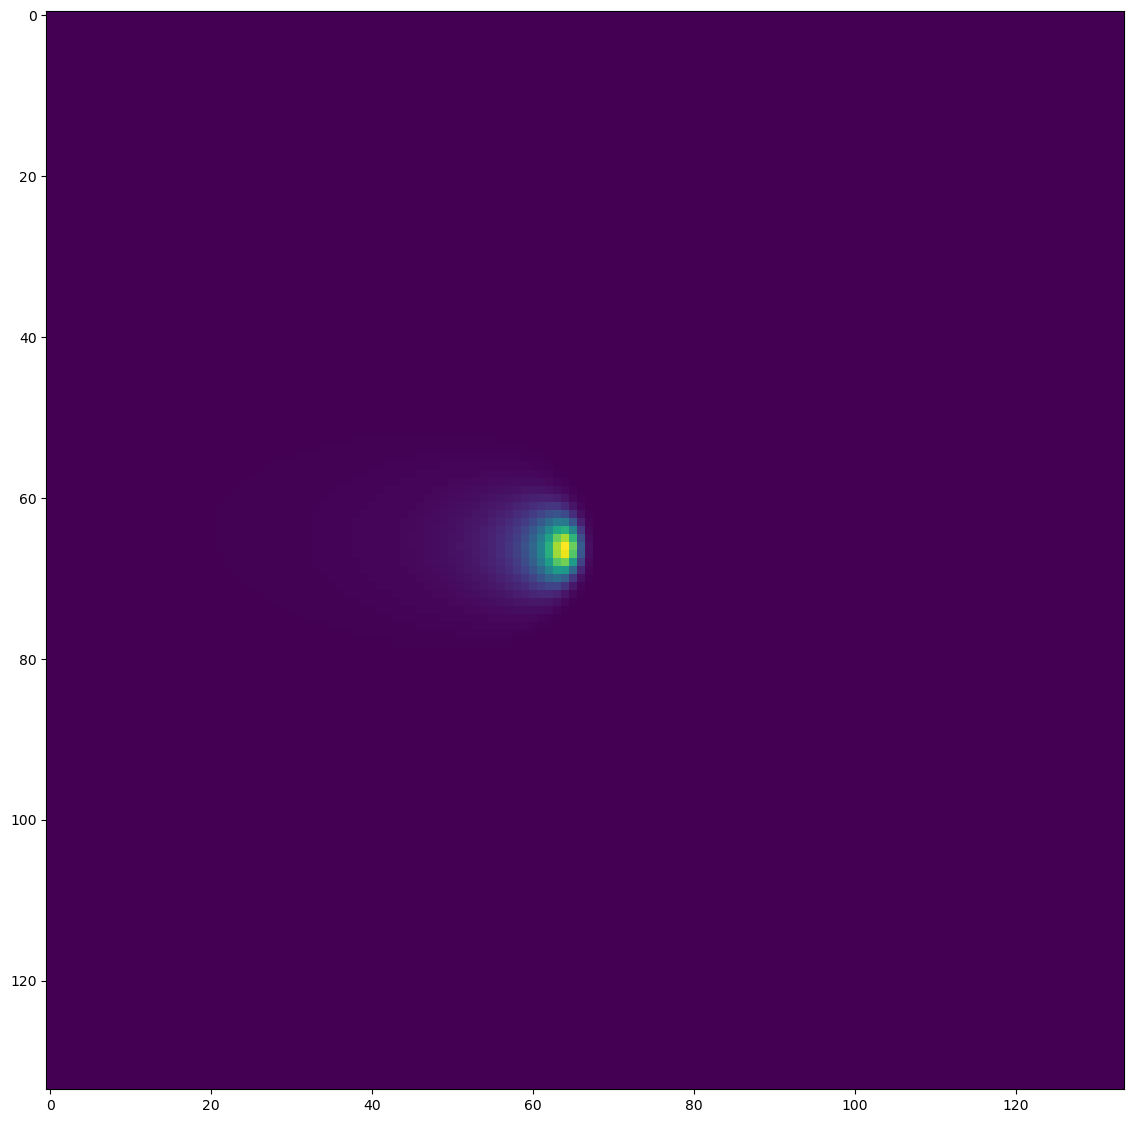

<Axes: >

In [11]:
# view a band for the hour of 10:00 AM (4th band)
plt.figure(figsize=(14,14))
src = rasterio.open("../../footprints/data/2011-01-01_US-CRT.tif")
show(src.read(4))